JOB CLASSIFICATION MODEL

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/job_description.csv")
df.head()

,Unnamed: 0,Category,Description,Benefits,Requirement,Requirements
0,0,Business Analyst,Description\nJob Title: Junior Business Analys...,Benefits\nMethods is passionate about its peop...,Requirements\n• Confidence in communicating an...,NaN
1,1,Business Analyst,Description\nThe Business Analyst (BA) will ca...,Benefits\nA competitive base salary\nBonus sch...,Requirements\nYou have…\nA methodical approach...,NaN
2,2,Business Analyst,Description\nWe help our clients design and de...,Benefits\nWe have 2 promotion windows open eac...,"Requirements\nYou are open, curious, and excit...",NaN
3,3,Business Analyst,Description\nFounded in 2015 and rapidly expan...,Benefits\nIn addition to a competitive package...,Requirements\nKey Responsibilities Include:\nP...,NaN
4,4,Business Analyst,Description\nWe are seeking a skilled Business...,Benefits\nFood Allowance\nGovernment Benefits\...,Requirements\nBachelor's Degree in management ...,NaN


In [3]:
df.describe()

,Unnamed: 0
count,325.000000
mean,162.000000
std,93.963645
min,0.000000
25%,81.000000
50%,162.000000
75%,243.000000
max,324.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    325 non-null    int64 
 1   Category      325 non-null    object
 2   Description   316 non-null    object
 3   Benefits      272 non-null    object
 4   Requirement   54 non-null     object
 5   Requirements  261 non-null    object
dtypes: int64(1), object(5)
memory usage: 15.4+ KB


In [5]:
df.isnull().sum()

Unnamed: 0        0
Category          0
Description       9
Benefits         53
Requirement     271
Requirements     64
dtype: int64

In [6]:
df.drop(columns=['Requirements', 'Requirement', 'Benefits', 'Unnamed: 0'], inplace=True)
df.dropna(inplace=True)

In [7]:
df.head()

,Category,Description
0,Business Analyst,Description\nJob Title: Junior Business Analys...
1,Business Analyst,Description\nThe Business Analyst (BA) will ca...
2,Business Analyst,Description\nWe help our clients design and de...
3,Business Analyst,Description\nFounded in 2015 and rapidly expan...
4,Business Analyst,Description\nWe are seeking a skilled Business...


In [8]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

In [9]:
df["cleaned_text"] = df["Description"].apply(preprocess_text)

In [10]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("naver/splade-cocondenser-ensembledistil")
model = AutoModelForMaskedLM.from_pretrained("naver/splade-cocondenser-ensembledistil")


In [11]:
def splade_encode(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits.squeeze(0)
    sparse_vector = torch.nn.functional.relu(logits).sum(dim=0).cpu().numpy()
    return sparse_vector

In [12]:
df["splade_vector"] = df["cleaned_text"].apply(splade_encode)

X = np.stack(df["splade_vector"].values)
y = df["Category"].values

In [21]:
df.head()

,Category,Description,cleaned_text,splade_vector
0,Business Analyst,Description\nJob Title: Junior Business Analys...,description job title junior business analyst ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Business Analyst,Description\nThe Business Analyst (BA) will ca...,description the business analyst ba will captu...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Business Analyst,Description\nWe help our clients design and de...,description we help our clients design and del...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Business Analyst,Description\nFounded in 2015 and rapidly expan...,description founded in 2015 and rapidly expand...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Business Analyst,Description\nWe are seeking a skilled Business...,description we are seeking a skilled business ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
svm_model = SVC(kernel="linear", C=1.0, class_weight="balanced")
svm_model.fit(x_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [15]:
y_pred = svm_model.predict(x_test)

print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

  Business Analyst       0.73      1.00      0.85        11
             Cloud       0.71      0.56      0.62         9
    Data Scientist       1.00      0.90      0.95        21
                HR       0.50      0.50      0.50         4
Software Developer       0.78      0.78      0.78        18
             UI/UX       1.00      1.00      1.00         1

          accuracy                           0.81        64
         macro avg       0.79      0.79      0.78        64
      weighted avg       0.82      0.81      0.81        64



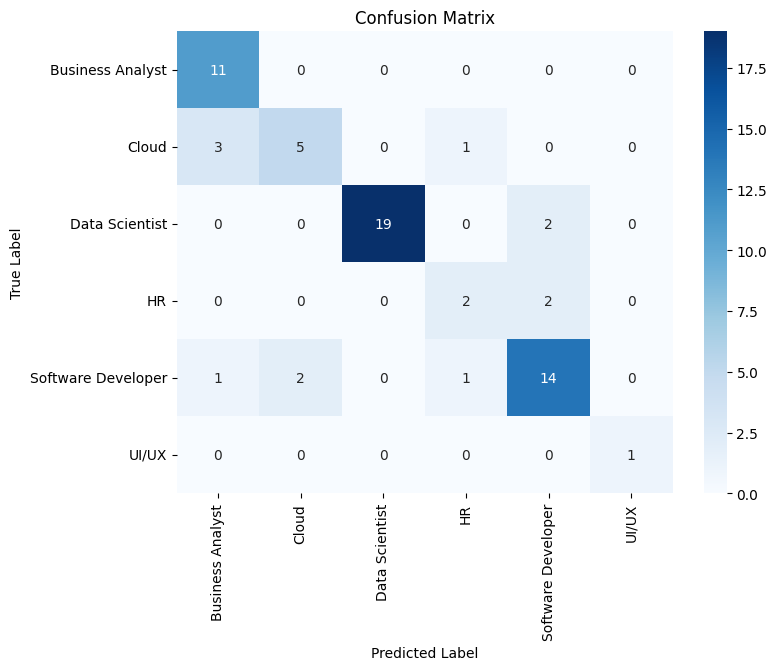

In [16]:
cm = confusion_matrix(y_test, y_pred)

class_labels = np.unique(y_test) 

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

JOB RECOMMENDATION MODEL (CONTENT BASED FILTERING AND COLLABORATIVE BASED FILTERING)

In [43]:
df_1 = pd.read_csv("data/user_profiles.csv") 
df_1.head()

,ID,Name,Skills,Education,Work Experience
0,1,Nicholas Miller,"Data Analysis, Java, HTML, Python",MBA,2 years
1,2,Austin Sutton Jr.,"HTML, Node.js, Java",M.Tech AI,2 years
2,3,Troy Hamilton,"Flask, Java, SQL, Docker",BBA,Intern
3,4,Perry Nelson,"Python, HTML",MBA,Intern
4,5,Lauren Nelson,"JavaScript, SQL",B.Com,Intern


In [44]:
df_1.describe()

,ID
count,300.000000
mean,150.500000
std,86.746758
min,1.000000
25%,75.750000
50%,150.500000
75%,225.250000
max,300.000000


In [45]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               300 non-null    int64 
 1   Name             300 non-null    object
 2   Skills           300 non-null    object
 3   Education        300 non-null    object
 4   Work Experience  300 non-null    object
dtypes: int64(1), object(4)
memory usage: 11.8+ KB


In [46]:
df_1.isnull().sum()

ID                 0
Name               0
Skills             0
Education          0
Work Experience    0
dtype: int64

1. CONTENT BASED FILTERING

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

job_vectors = np.vstack(df["splade_vector"])

def recommend_jobs(user_profile):
    user_description = f"{user_profile['Skills']} {user_profile['Education']} {user_profile['Work Experience']}"
    
    user_vector = splade_encode(user_description)

    user_vector = user_vector.reshape(1, -1)

    similarity_scores = cosine_similarity(user_vector, job_vectors).flatten()

    #recommending top 10 jobs
    top_n = 10
    top_indices = np.argsort(similarity_scores)[-top_n:][::-1]

    recommendations = [
        {
            "Job Title": df.iloc[i]["Category"], 
            "Description": df.iloc[i]["Description"], 
            "Similarity": float(similarity_scores[i])
        }
        for i in top_indices
    ]
    
    return recommendations

#recommending jobs for the 10th user in the database
user_profile = df_1.iloc[10]
recommended_jobs = recommend_jobs(user_profile)

df_recommendations = pd.DataFrame(recommended_jobs)
df_recommendations



,Job Title,Description,Similarity
0,Software Developer,Description\nThe Company\nVaticle is a team of...,0.304344
1,Data Scientist,Description\nData Analysis: Perform advanced d...,0.289996
2,Data Scientist,Description\nData Analysis: Perform advanced d...,0.289996
3,Software Developer,Description\nWhy Join Us?\nAre you looking for...,0.287298
4,Software Developer,Description\nAt RedLight we build meaningful s...,0.287053
5,Software Developer,Description\nTitle – . Java Back End Developer...,0.285391
6,Software Developer,Description\nWe are looking for a highly motiv...,0.274870
7,Software Developer,Description\nWe are working on modern software...,0.270101
8,Software Developer,Description\nResource Innovations is seeking a...,0.261727
9,Software Developer,Description\nAbout Electrum\nElectrum is an ex...,0.254969


2. COLLABORATIVE BASED FILTERING

In [51]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

df["splade_vector"] = df["splade_vector"].apply(lambda x: np.array(x) if isinstance(x, list) else x)
X = np.stack(df["splade_vector"].values)

num_clusters = df["Category"].nunique()
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, df["Cluster"])  

def recommend_jobs(user_profile):
    user_description = f"{user_profile['Skills']} {user_profile['Education']} {user_profile['Work Experience']}"

    user_vector = splade_encode(user_description).reshape(1, -1)

    cluster_distances = np.linalg.norm(kmeans.cluster_centers_ - user_vector, axis=1)

    cluster_probs = 1 / (cluster_distances + 1e-6)  
    cluster_probs /= cluster_probs.sum()

    top_n_clusters = 2
    top_clusters = np.argsort(cluster_probs)[-top_n_clusters:][::-1]

    print(f"User belongs to clusters: {top_clusters} with probabilities: {cluster_probs[top_clusters]}")

    filtered_jobs = df[df["Cluster"].isin(top_clusters)]

    cluster_vectors = np.stack(filtered_jobs["splade_vector"].values)
    similarity_scores = cosine_similarity(user_vector, cluster_vectors).flatten()

    top_n = 5
    top_indices = np.argsort(similarity_scores)[-top_n:][::-1]

    recommendations = [
        {
            "Category": filtered_jobs.iloc[i]["Category"], 
            "Description": filtered_jobs.iloc[i]["Description"], 
            "Similarity": float(similarity_scores[i])
        }
        for i in top_indices
    ]

    return recommendations

for idx, user_profile in df_1.head(5).iterrows():
    print(f"\n🔹 Recommendations for User {idx+1} 🔹\n")
    
    recommended_jobs = recommend_jobs(user_profile)
    
    df_recommendations = pd.DataFrame(recommended_jobs)
    df_recommendations




🔹 Recommendations for User 1 🔹

User belongs to clusters: [0 2] with probabilities: [0.33831045 0.25537586]

🔹 Recommendations for User 2 🔹

User belongs to clusters: [0 2] with probabilities: [0.3393594  0.25239846]

🔹 Recommendations for User 3 🔹

User belongs to clusters: [0 2] with probabilities: [0.34160662 0.253753  ]

🔹 Recommendations for User 4 🔹

User belongs to clusters: [0 2] with probabilities: [0.33275425 0.2553806 ]

🔹 Recommendations for User 5 🔹

User belongs to clusters: [0 2] with probabilities: [0.33131242 0.2557076 ]


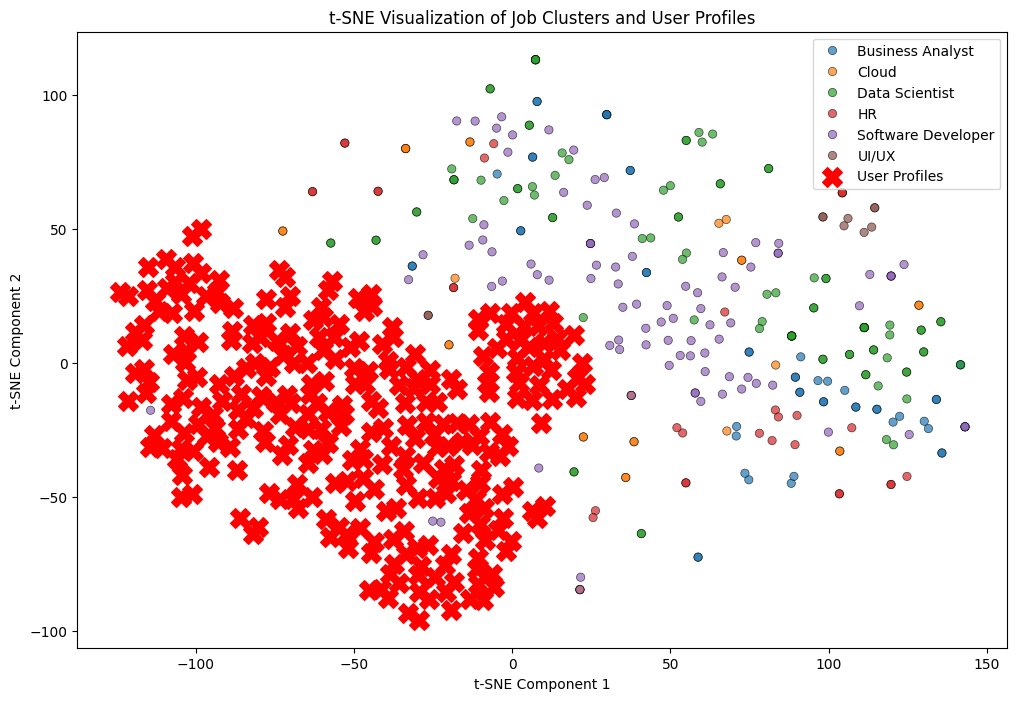

In [ ]:
#Plotting a t-SNE plot
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

df["splade_vector"] = df["splade_vector"].apply(lambda x: np.array(x) if isinstance(x, list) else x)
X = np.stack(df["splade_vector"].values)

num_clusters = df["Category"].nunique()
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X)

user_vectors = []
for _, user_profile in df_1.iterrows():
    user_description = f"{user_profile['Skills']} {user_profile['Education']} {user_profile['Work Experience']}"
    user_vector = splade_encode(user_description).flatten()
    user_vectors.append(user_vector)

user_vectors = np.stack(user_vectors)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(np.vstack([X, user_vectors]))

job_tsne = X_tsne[: len(df)]
user_tsne = X_tsne[len(df) :]

plt.figure(figsize=(12, 8))
sns.scatterplot(x=job_tsne[:, 0], y=job_tsne[:, 1], hue=df["Category"], palette="tab10", alpha=0.7, edgecolor="k")
plt.scatter(user_tsne[:, 0], user_tsne[:, 1], color="red", marker="X", s=200, label="User Profiles")
plt.legend()
plt.title("t-SNE Visualization of Job Clusters and User Profiles")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
